# WEEKLY FORECASTING

## IMPORTS

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
color_pal = sns.color_palette()
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.arima import ARIMA
from sktime.forecasting.model_selection import ExpandingWindowSplitter
from sktime.forecasting.model_evaluation import evaluate
from sktime.forecasting.model_selection import ForecastingGridSearchCV
from sktime.forecasting.compose import make_reduction
from sktime.forecasting.compose import EnsembleForecaster
from sktime.performance_metrics.forecasting import MeanAbsoluteError
from sktime.performance_metrics.forecasting import MeanSquaredError
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError
from sklearn.neural_network import MLPRegressor
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings("ignore")

## FUNCTIONS

In [2]:
def ADFtest(mydata):
    adf = adfuller(mydata)
    if adf[0] >= adf[4]['5%']:
        print(' is not stationary')
    else:
        print('is stationary')

In [3]:
def residuals_plots(residuals):
   fig = plt.figure(figsize=(5.5, 3.5), layout="constrained")
   spec = fig.add_gridspec(3, 2)
#plot
   ax1 = fig.add_subplot(spec[0, :])
   residuals.plot(style='-', figsize=(80,80), color='blue', linewidth=8, ax = ax1)
   ax1.set_xlabel('Time', fontsize = 80)
   ax1.xaxis.set_tick_params(labelsize=80)
   ax1.set_ylabel('errors', fontsize = 80)
   ax1.yaxis.set_tick_params(labelsize=80)
   ax1.set_title('RESIDUALS', fontsize= 90)
   ax1.legend().set_visible(False)
   ax1.grid(linewidth=6)
   ax1.spines['top'].set_linewidth(3)
   ax1.spines['right'].set_linewidth(3)
   ax1.spines['left'].set_linewidth(3)
   ax1.spines['bottom'].set_linewidth(3)
#histogram
   ax2 = fig.add_subplot(spec[1, :])
   residuals.plot(kind='hist', bins=10, figsize=(80,80), ax = ax2)
   ax2.set_xlabel('Price', fontsize = 80)
   ax2.xaxis.set_tick_params(labelsize=80)
   ax2.set_ylabel('Frequency', fontsize =80)
   ax2.yaxis.set_tick_params(labelsize=80)
   ax2.set_title('HISTOGRAM', fontsize= 90)
   ax2.legend().set_visible(False)
   ax2.grid(linewidth=6)
   ax2.spines['top'].set_linewidth(3)
   ax2.spines['right'].set_linewidth(3)
   ax2.spines['left'].set_linewidth(3)
   ax2.spines['bottom'].set_linewidth(3)
#acf plot
   ax3 = fig.add_subplot(spec[2, 0])
   plot_acf(residuals,zero=False, ax=ax3, lags= 10, linewidth = 8, vlines_kwargs={"linewidth": 8})
   ax3.set_xticks(np.arange(1,11))
   ax3.set_ylim([-.3,.3]) 
   ax3.xaxis.set_tick_params(labelsize=80)
   ax3.yaxis.set_tick_params(labelsize=80)
   ax3.set_title('AUTOCORRELATION', fontsize= 90)
   ax3.spines['top'].set_linewidth(3)
   ax3.spines['right'].set_linewidth(3)
   ax3.spines['left'].set_linewidth(3)
   ax3.spines['bottom'].set_linewidth(3)
#pacf plot
   ax4 = fig.add_subplot(spec[2, 1])
   plot_pacf(residuals,zero=False, ax=ax4, lags = 10, linewidth = 8, vlines_kwargs={"linewidth": 8})
   ax4.set_xticks(np.arange(1,11)) 
   ax4.set_ylim([-.3,.3]) 
   ax4.xaxis.set_tick_params(labelsize=80)
   ax4.yaxis.set_tick_params(labelsize=80)
   ax4.set_title('PARTIAL AUTOCORRELATION', fontsize= 90)
   ax4.spines['top'].set_linewidth(3)
   ax4.spines['right'].set_linewidth(3)
   ax4.spines['left'].set_linewidth(3)
   ax4.spines['bottom'].set_linewidth(3)

   fig.tight_layout(pad=10)
   plt.show()

In [4]:
def nn_residuals(window_size,estimator):
    frame = train.copy()
    for window in range(1, window_size+1):
        frame[f"lag {str(window)}"] = train.shift(window)        
    frame= frame.dropna()    
    y = frame['price']
    X = frame.loc[:,frame.columns != 'price']       
    estimator.fit(X,y)    
    fitted_values = pd.Series(estimator.predict(X), index = train[window_size:].index)    
    residuals = y - fitted_values   
    return residuals

# ANALYSIS

## main data

In [5]:
maindata = pd.read_excel('merge_file_EnEx.xlsx', dtype = ({'time': np.dtype(str) , 'price': np.float64}))
maindata = maindata.set_index('time')
maindata.index = pd.to_datetime(maindata.index)
maindata

price
time                       
2020-11-01 00:00:00   59.52
2020-11-01 01:00:00   59.01
2020-11-01 02:00:00   59.01
2020-11-01 03:00:00   59.01
2020-11-01 04:00:00   59.01
...                     ...
2023-02-28 19:00:00  194.18
2023-02-28 20:00:00  174.69
2023-02-28 21:00:00  159.57
2023-02-28 22:00:00  154.68
2023-02-28 23:00:00  152.09

[20400 rows x 1 columns]

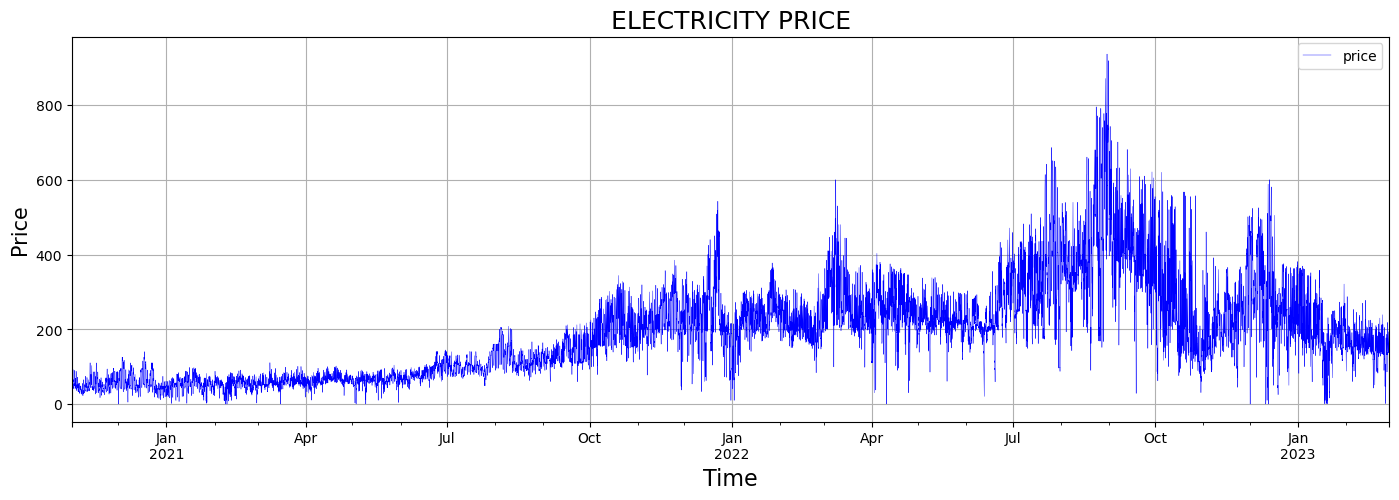

In [6]:
maindata.plot(style='-', figsize=(17,5), color='blue', linewidth=0.3)
plt.xlabel('Time', fontsize = 16)
plt.ylabel('Price', fontsize = 15)
plt.title('ELECTRICITY PRICE', fontsize= 18)
plt.grid()
plt.show()

## fill NaN

In [7]:
np.where(np.isnan(maindata))

(array([ 3551, 12287], dtype=int64), array([0, 0], dtype=int64))

In [8]:
maindata.iloc[3551] = maindata.iloc[3551-168]

In [9]:
maindata.iloc[12287] = maindata.iloc[12287-168]

In [10]:
np.where(np.isnan(maindata))

(array([], dtype=int64), array([], dtype=int64))

## Weekly data

In [11]:
data = maindata.resample('W').mean()

In [12]:
len(data)

123

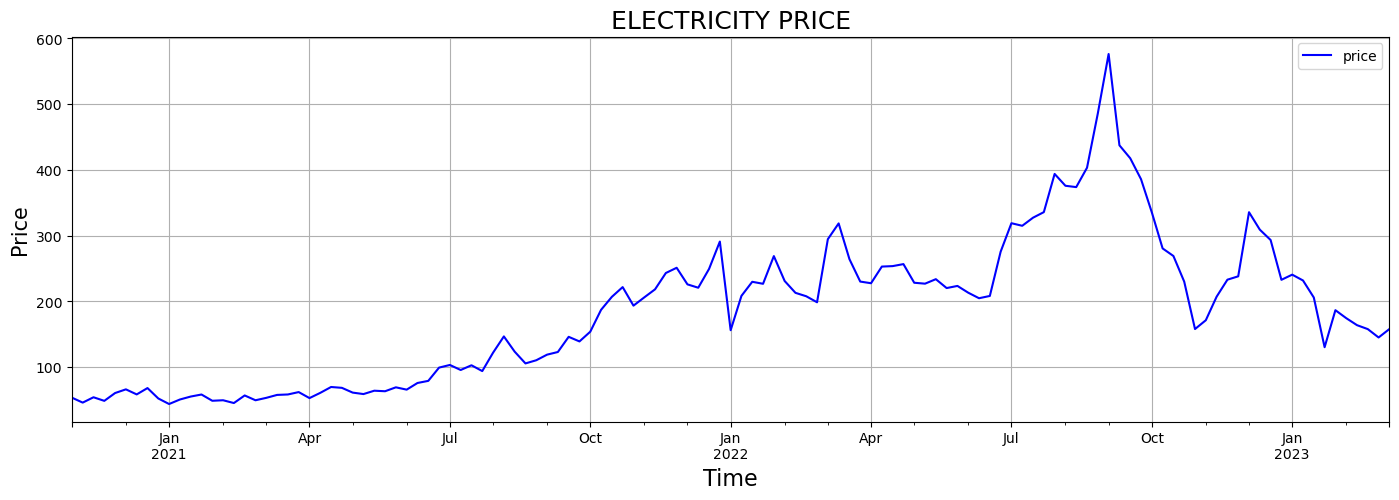

In [13]:
data.plot(style='-', figsize=(17,5), color='blue', linewidth=1.5)
plt.xlabel('Time', fontsize = 16)
plt.ylabel('Price', fontsize = 15)
plt.title('ELECTRICITY PRICE', fontsize= 18)
plt.grid()
plt.show()

## cross validation

In [14]:
cv= ExpandingWindowSplitter(initial_window = 100, fh= 1)

## split train-test data

In [15]:
train,test = temporal_train_test_split(data,test_size=23)

# FORECASTERS

## NAIVE FORECASTER

In [16]:
nforecaster = NaiveForecaster('last')
nforecaster.fit(train)

NaiveForecaster()

## residuals

In [17]:
nresid = nforecaster.predict_residuals(train)

In [17]:
residuals_plots(nresid)

## forecast

In [18]:
cv_naive1 = evaluate(strategy='refit', forecaster=nforecaster, cv=cv,y=data, return_data=True, scoring = MeanSquaredError(square_root=True))
cv_naive2 = evaluate(strategy='refit', forecaster=nforecaster, cv=cv,y=data, return_data=True, scoring= MeanAbsolutePercentageError())
cv_naive3 = evaluate(strategy='refit', forecaster=nforecaster, cv=cv,y=data, return_data=True, scoring= MeanAbsoluteError())

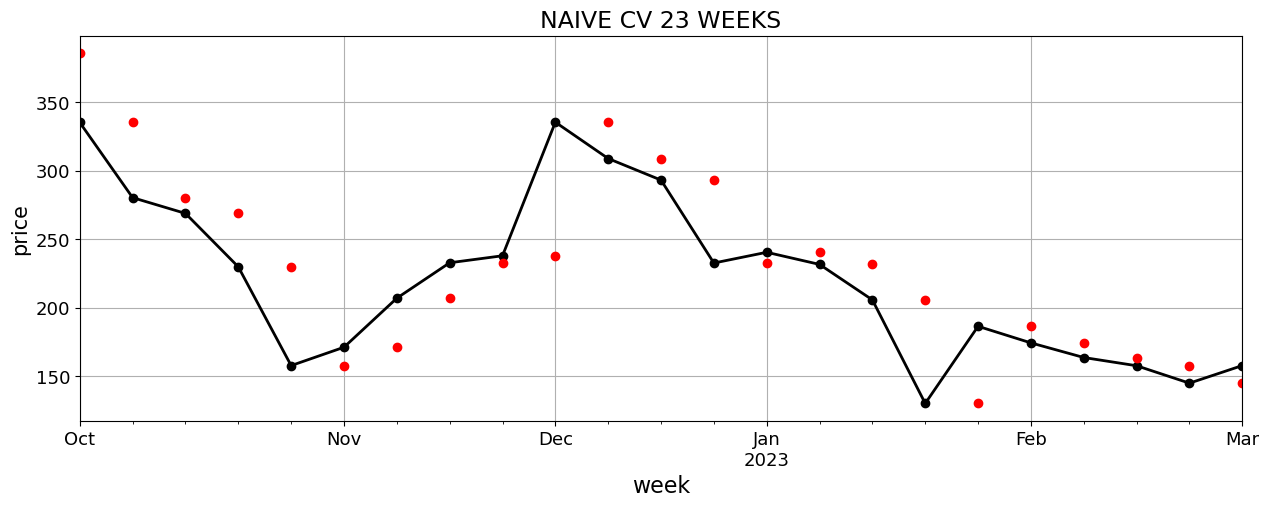

In [19]:
ax = data.iloc[-23:].plot(color='black',marker='o', figsize=(15,5), linewidth=2, fontsize = 13)
for i in range(len(cv_naive1)):
  cv_naive1['y_pred'].iloc[i].plot(ax=ax,color='red', marker = 'o')
ax.get_legend().remove()
plt.xlabel('week', fontsize = 16)
plt.ylabel('price', fontsize = 15)
plt.title('NAIVE CV 23 WEEKS', fontsize = 17)
plt.grid()
plt.show()

## train metrics

In [19]:
nRMSEtrain = np.sqrt(np.square(nresid['price']).mean())
nMAPEtrain = np.absolute(nresid['price']).mean()
nMAEtrain = np.absolute(nresid['price']/train['price']).mean()

## test metrics

In [20]:
nRMSEtest = np.sqrt(cv_naive1["test_MeanSquaredError"]).mean()
nMAPEtest = cv_naive2["test_MeanAbsolutePercentageError"].mean()
nMAEtest = cv_naive3["test_MeanAbsoluteError"].mean()

## ARIMA FORECASTER

## orders selection

In [21]:
log_data = np.log(data)
ADFtest(log_data)

 is not stationary


In [22]:
datad = log_data.diff().dropna()
ADFtest(datad)

is stationary


In [23]:
fig = plt.figure(figsize=(5.5, 3.5), layout="constrained")
spec = fig.add_gridspec(3, 2)
#logged data
ax1 = fig.add_subplot(spec[0, :])
log_data.plot(style='-', figsize=(80,80), color='blue', linewidth=8, ax = ax1)
ax1.set_xlabel('Time', fontsize = 80)
ax1.xaxis.set_tick_params(labelsize=80)
ax1.set_ylabel('logged price', fontsize = 80)
ax1.yaxis.set_tick_params(labelsize=80)
ax1.set_title('LOGGED DATA', fontsize= 90)
ax1.legend().set_visible(False)
ax1.grid(linewidth=6)
ax1.spines['top'].set_linewidth(3)
ax1.spines['right'].set_linewidth(3)
ax1.spines['left'].set_linewidth(3)
ax1.spines['bottom'].set_linewidth(3)
#diff logged data
ax2 = fig.add_subplot(spec[1, :])
datad.plot(style='-', figsize=(80,80), color='blue', linewidth=8, ax = ax2)
ax2.set_xlabel('Time', fontsize = 80)
ax2.xaxis.set_tick_params(labelsize=80)
ax2.set_ylabel('diff price', fontsize =80)
ax2.yaxis.set_tick_params(labelsize=80)
ax2.set_title('DIFF LOGGED DATA', fontsize= 90)
ax2.legend().set_visible(False)
ax2.grid(linewidth=6)
ax2.spines['top'].set_linewidth(3)
ax2.spines['right'].set_linewidth(3)
ax2.spines['left'].set_linewidth(3)
ax2.spines['bottom'].set_linewidth(3)
#acf plot
ax3 = fig.add_subplot(spec[2, 0])
plot_acf(datad,zero=False, ax=ax3, lags= 10, linewidth = 8, vlines_kwargs={"linewidth": 8})
ax3.xaxis.set_tick_params(labelsize=80)
ax3.yaxis.set_tick_params(labelsize=80)
ax3.set_ylim([-.2,.2]) 
ax3.set_title('AUTOCORRELATION', fontsize= 90)
ax3.spines['top'].set_linewidth(3)
ax3.spines['right'].set_linewidth(3)
ax3.spines['left'].set_linewidth(3)
ax3.spines['bottom'].set_linewidth(3)
#pacf plot
ax4 = fig.add_subplot(spec[2, 1])
plot_pacf(datad,zero=False, ax=ax4, lags = 10, linewidth = 8, vlines_kwargs={"linewidth": 8})
ax4.xaxis.set_tick_params(labelsize=80)
ax4.yaxis.set_tick_params(labelsize=80)
ax4.set_ylim([-.2,.2]) 
ax4.set_title('PARTIAL AUTOCORRELATION', fontsize= 90)
ax4.spines['top'].set_linewidth(3)
ax4.spines['right'].set_linewidth(3)
ax4.spines['left'].set_linewidth(3)
ax4.spines['bottom'].set_linewidth(3)

fig.tight_layout(pad=10)
plt.show()

In [24]:
aforecaster = ARIMA(order = (0,1,0), with_intercept=False)
aforecaster.fit(train)

ARIMA(order=(0, 1, 0), with_intercept=False)

In [25]:
aforecaster.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  100
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -482.791
Date:                Sun, 25 Jun 2023   AIC                            967.582
Time:                        11:40:37   BIC                            970.178
Sample:                    11-01-2020   HQIC                           968.632
                         - 09-25-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1007.7678     68.948     14.616      0.000     872.631    1142.904
===================================================================================
Ljung-Box (L1) (Q):                   0.49   Jarque-Bera (JB):               233.10
Prob(Q):                              0.48   Prob(JB):                         0.00
Heteroskedasticity (H):              37.28   Skew:                            -1.04
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.22
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## residuals

In [26]:
aresid = aforecaster.predict_residuals(train)

In [28]:
residuals_plots(aresid.dropna())

## forecast

In [27]:
cv_arima1 = evaluate(strategy='refit', forecaster=aforecaster, cv=cv, y=data, return_data=True, scoring=MeanSquaredError(square_root=True))
cv_arima2 = evaluate(strategy='refit', forecaster=aforecaster, cv=cv, y=data, return_data=True, scoring = MeanAbsolutePercentageError())
cv_arima3 = evaluate(strategy='refit', forecaster=aforecaster, cv=cv, y=data, return_data=True, scoring = MeanAbsoluteError())

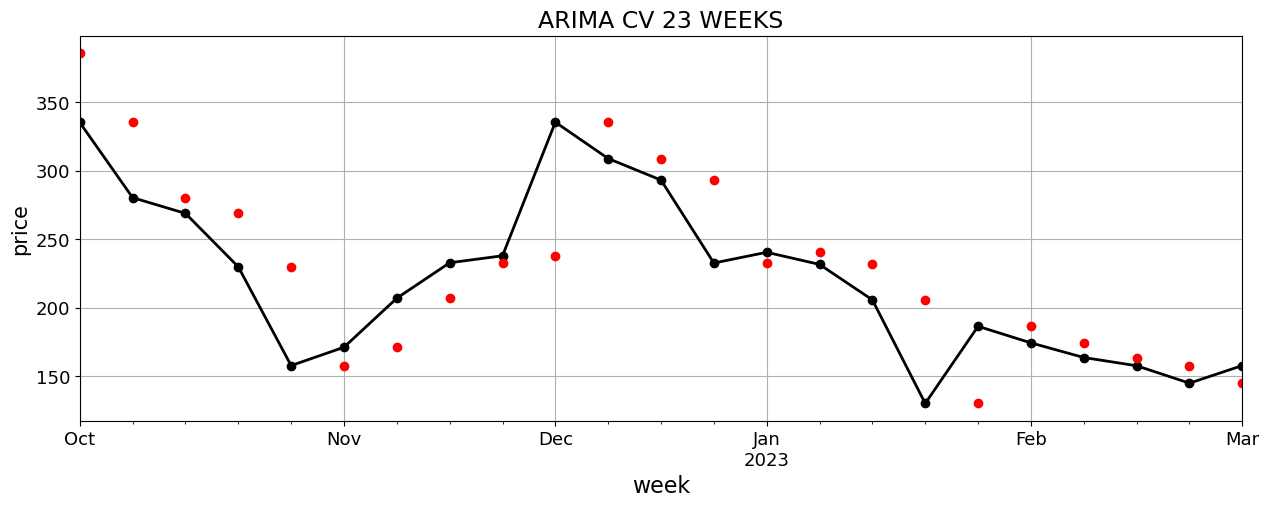

In [30]:
ax = data.iloc[-23:].plot(color='black',marker='o', figsize=(15,5), linewidth=2, fontsize = 13)
for i in range(len(cv_arima1)):
  cv_arima1['y_pred'].iloc[i].plot(ax=ax,color='red', marker = 'o')
ax.get_legend().remove()
plt.xlabel('week', fontsize = 16)
plt.ylabel('price', fontsize = 15)
plt.title('ARIMA CV 23 WEEKS', fontsize = 17)
plt.grid()
plt.show()

## train metrics

In [28]:
aRMSEtrain = np.sqrt(np.square(aresid['price']).mean())
aMAPEtrain = np.absolute(aresid['price']).mean()
aMAEtrain = np.absolute(aresid['price']/train['price']).mean()

## test metrics

In [29]:
aRMSEtest = np.sqrt(cv_arima1["test_MeanSquaredError"]).mean()
aMAPEtest = cv_arima2["test_MeanAbsolutePercentageError"].mean()
aMAEtest = cv_arima3["test_MeanAbsoluteError"].mean()

## AUTOARIMA FORECASTER

## orders selection

In [30]:
autoforecaster = AutoARIMA(d=1)

In [31]:
autoforecaster.fit(data)

AutoARIMA(d=1)

In [32]:
autoforecaster.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  123
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -602.325
Date:                Sun, 25 Jun 2023   AIC                           1206.650
Time:                        11:41:04   BIC                           1209.454
Sample:                    11-01-2020   HQIC                          1207.788
                         - 03-05-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1137.1824     81.588     13.938      0.000     977.274    1297.091
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               107.63
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):              20.32   Skew:                            -0.61
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.44
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [33]:
aaforecaster = ARIMA(order = (0,1,0), with_intercept=False)
aaforecaster.fit(train)

ARIMA(order=(0, 1, 0), with_intercept=False)

## residuals

In [34]:
aaresid = aaforecaster.predict_residuals(train)

In [38]:
residuals_plots(aaresid.dropna())

## forecast

In [35]:
cv_autoarima1 = evaluate(strategy='refit',forecaster=aaforecaster,cv=cv,y=data,return_data=True,scoring=MeanSquaredError(square_root=True))
cv_autoarima2 = evaluate(strategy='refit',forecaster=aaforecaster,cv=cv,y=data,return_data=True, scoring = MeanAbsolutePercentageError())
cv_autoarima3 = evaluate(strategy='refit',forecaster=aaforecaster,cv=cv,y=data,return_data=True, scoring = MeanAbsoluteError())

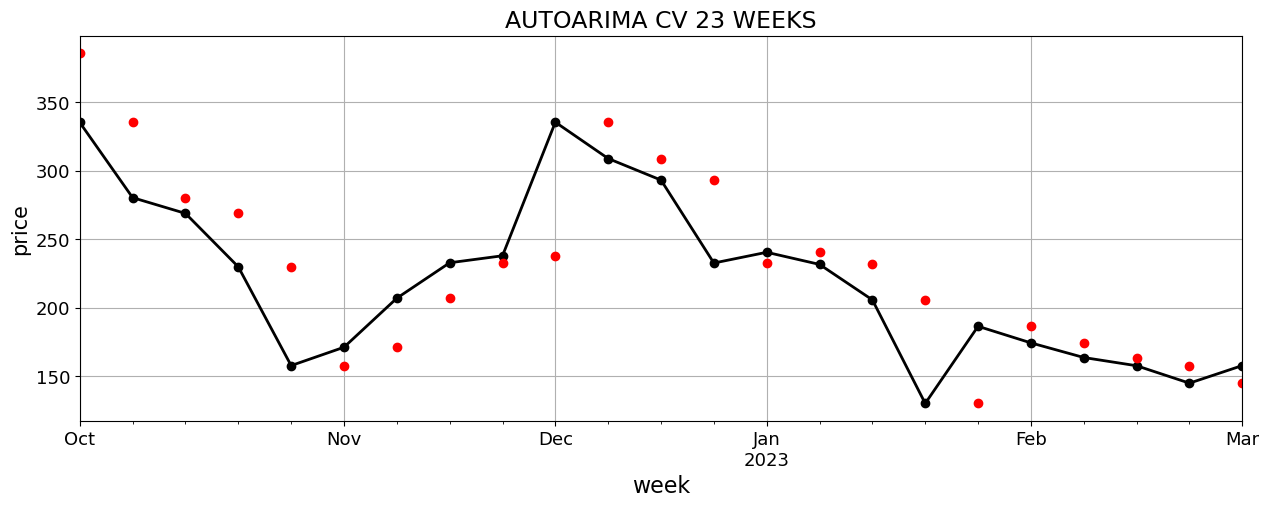

In [40]:
ax = data.iloc[-23:].plot(color='black',marker='o', figsize=(15,5), linewidth=2, fontsize = 13)
for i in range(len(cv_autoarima1)):
  cv_autoarima1['y_pred'].iloc[i].plot(ax=ax,color='red', marker = 'o')
ax.get_legend().remove()
plt.xlabel('week', fontsize = 16)
plt.ylabel('price', fontsize = 15)
plt.title('AUTOARIMA CV 23 WEEKS', fontsize = 17)
plt.grid()
plt.show()

## train metrics

In [36]:
aaRMSEtrain = np.sqrt(np.square(aaresid['price']).mean())
aaMAPEtrain = np.absolute(aaresid['price']).mean()
aaMAEtrain = np.absolute(aaresid['price']/train['price']).mean()

## test metrics

In [37]:
aaRMSEtest = np.sqrt(cv_autoarima1["test_MeanSquaredError"]).mean()
aaMAPEtest = cv_autoarima2["test_MeanAbsolutePercentageError"].mean()
aaMAEtest = cv_autoarima3["test_MeanAbsoluteError"].mean()

## EXPONENTIAL SMOOTHING FORECASTER

In [38]:
esforecaster = ExponentialSmoothing(trend = 'add')
esforecaster.fit(train)

ExponentialSmoothing(trend='add')

## residuals

In [39]:
esresid = esforecaster.predict_residuals(train)

In [45]:
residuals_plots(esresid)

## forecast

In [40]:
cv_ETS1 = evaluate(strategy='refit',forecaster=esforecaster,cv=cv,y=data,return_data=True,scoring=MeanSquaredError(square_root=True))
cv_ETS2 = evaluate(strategy='refit',forecaster=esforecaster,cv=cv,y=data,return_data=True, scoring= MeanAbsolutePercentageError())
cv_ETS3 = evaluate(strategy='refit',forecaster=esforecaster,cv=cv,y=data,return_data=True, scoring= MeanAbsoluteError())

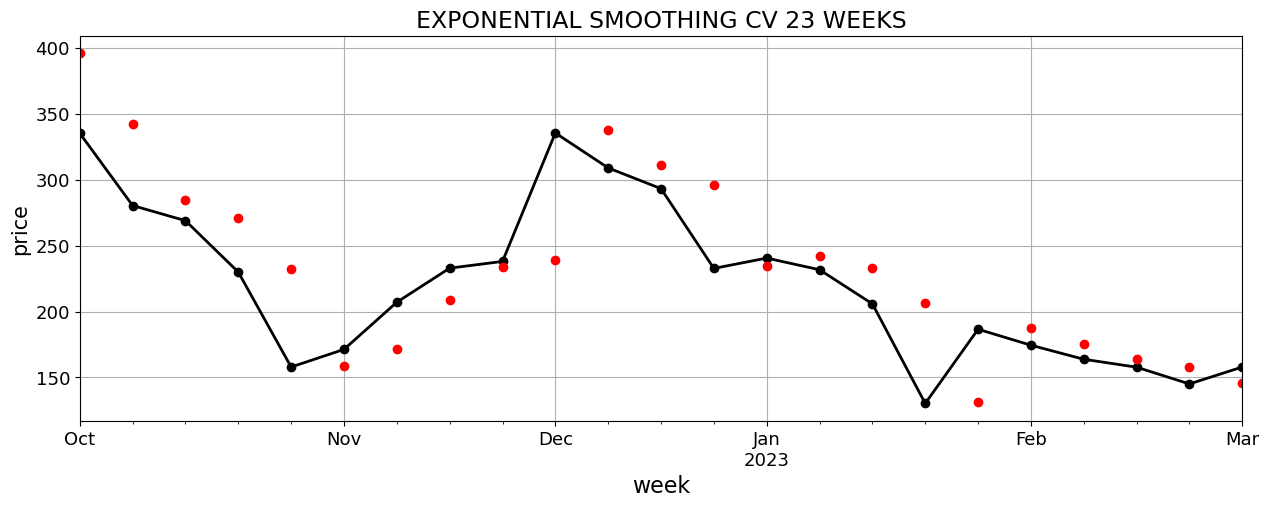

In [47]:
ax = data.iloc[-23:].plot(color='black',marker='o', figsize=(15,5), linewidth=2, fontsize = 13)
for i in range(len(cv_ETS1)):
  cv_ETS1['y_pred'].iloc[i].plot(ax=ax,color='red', marker = 'o')
ax.get_legend().remove()
plt.xlabel('week', fontsize = 16)
plt.ylabel('price', fontsize = 15)
plt.title('EXPONENTIAL SMOOTHING CV 23 WEEKS', fontsize = 17)
plt.grid()
plt.show()

## train metrics

In [41]:
esRMSEtrain = np.sqrt(np.square(esresid['price']).mean())
esMAPEtrain = np.absolute(esresid['price']).mean()
esMAEtrain = np.absolute(esresid['price']/train['price']).mean()

## test metrics

In [42]:
esRMSEtest = np.sqrt(cv_ETS1["test_MeanSquaredError"]).mean()
esMAPEtest = cv_ETS2["test_MeanAbsolutePercentageError"].mean()
esMAEtest = cv_ETS3["test_MeanAbsoluteError"].mean()

## NEUTRAL NETWORKS

## forecasting grid search

In [59]:
cv1= ExpandingWindowSplitter(initial_window = 80, fh= 1, step_length = 1)

In [60]:
lst = []
k_values = range(1,20,4)
for k in k_values:
    lst.append(k,)
i_values = range(1,20,4)
j_values = range(1,20,4)
for i in i_values:
    for j in j_values:
        lst.append((i,j,))

In [61]:
parameters= {'estimator__hidden_layer_sizes': lst,
         'estimator__early_stopping': [True, False],
             'estimator__shuffle': [True, False],
             'window_length': [1,2,3]}
        

In [62]:
regressor = MLPRegressor(random_state=11, max_iter = 716)
forecaster = make_reduction(estimator = regressor, strategy='recursive')

In [63]:
grid_search = ForecastingGridSearchCV(forecaster = forecaster, cv=cv1, n_jobs =-1, param_grid = parameters, scoring=MeanSquaredError(square_root=True))

In [65]:
grid_search.fit(train)

ForecastingGridSearchCV(cv=ExpandingWindowSplitter(initial_window=80),
                        forecaster=RecursiveTabularRegressionForecaster(estimator=MLPRegressor(max_iter=716,
                                                                                               random_state=11)),
                        n_jobs=-1,
                        param_grid={'estimator__early_stopping': [True, False],
                                    'estimator__hidden_layer_sizes': [1, 5, 9,
                                                                      13, 17,
                                                                      (1, 1),
                                                                      (1, 5),
                                                                      (1, 9),
                                                                      (1, 13),
                                                                      (1, 17),
                                          

In [66]:
grid_search.best_params_

{'estimator__early_stopping': True,
 'estimator__hidden_layer_sizes': 13,
 'estimator__shuffle': True,
 'window_length': 1}

In [43]:
model = MLPRegressor(max_iter=716, hidden_layer_sizes=(13,), random_state= 11, shuffle= True, early_stopping=True)
nnforecaster = make_reduction(estimator = model, strategy='recursive', window_length=1)
nnforecaster.fit(train)

RecursiveTabularRegressionForecaster(estimator=MLPRegressor(early_stopping=True,
                                                            hidden_layer_sizes=(13,),
                                                            max_iter=716,
                                                            random_state=11),
                                     window_length=1)

## residuals

In [44]:
nnresid = nn_residuals(1,MLPRegressor(early_stopping=True,hidden_layer_sizes=(13,),max_iter=716,random_state=11))

In [45]:
nnresid = pd.DataFrame(nnresid, train.index)

In [46]:
nnresid = nnresid.rename(columns = {0:'price'})

In [96]:
residuals_plots(nnresid.dropna())

## forecast

In [47]:
cv_nn1 = evaluate(strategy='refit',forecaster=nnforecaster,cv=cv,y=data, return_data=True, scoring= MeanSquaredError(square_root=True), n_jobs =-1)
cv_nn2 = evaluate(strategy='refit',forecaster=nnforecaster,cv=cv,y=data, return_data=True, n_jobs =-1)
cv_nn3 = evaluate(strategy='refit',forecaster=nnforecaster,cv=cv,y=data, return_data=True, scoring= MeanAbsoluteError(), n_jobs =-1)

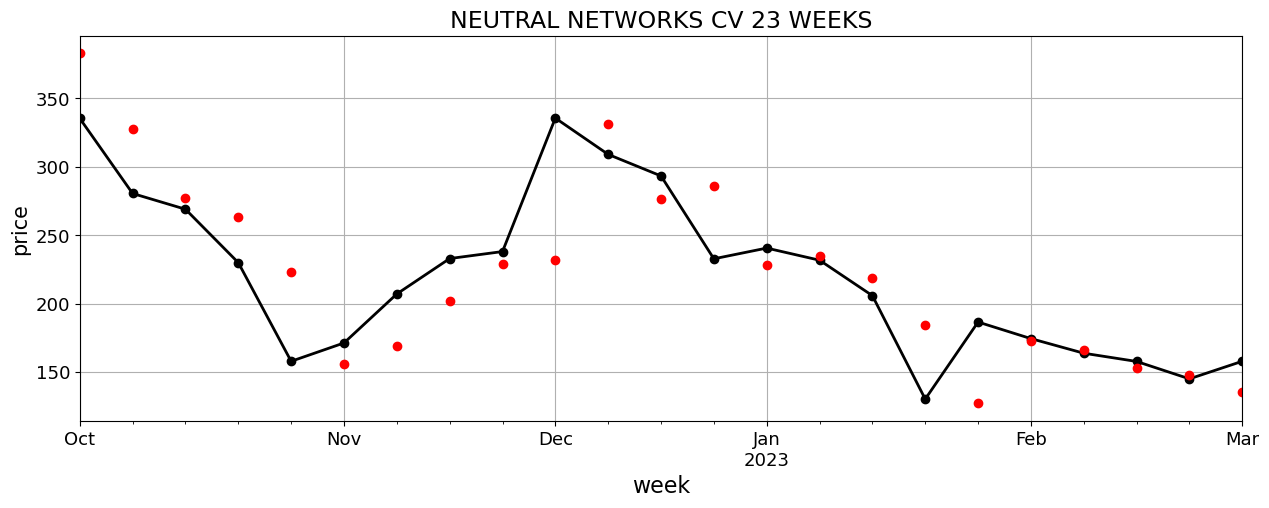

In [56]:
ax = data.iloc[-23:].plot(color='black',marker='o', figsize=(15,5), linewidth=2, fontsize = 13)
for i in range(len(cv_nn1)):
  cv_nn1['y_pred'].iloc[i].plot(ax=ax,color='red', marker = 'o')
ax.get_legend().remove()
plt.xlabel('week', fontsize = 16)
plt.ylabel('price', fontsize = 15)
plt.title('NEUTRAL NETWORKS CV 23 WEEKS', fontsize = 17)
plt.grid()
plt.show()

## train metrics

In [48]:
nnRMSEtrain = np.sqrt(np.square(nnresid['price']).mean())
nnMAPEtrain = np.absolute(nnresid['price']).mean()
nnMAEtrain = np.absolute(nnresid['price']/train['price']).mean()

## test metrics

In [49]:
nnRMSEtest = np.sqrt(cv_nn1["test_MeanSquaredError"]).mean()
nnMAPEtest = cv_nn2["test_MeanAbsolutePercentageError"].mean()
nnMAEtest = cv_nn3["test_MeanAbsoluteError"].mean()

## ENSEMBLE FORECASTER

In [50]:
estimator = MLPRegressor(max_iter=716, hidden_layer_sizes=(21,), random_state= 11, shuffle= False, early_stopping=False)
model1 = make_reduction(estimator = estimator, strategy='recursive', window_length=7)
model2 = ExponentialSmoothing(trend="add")
model3 = ARIMA(order = (0,1,0), with_intercept=False)
forecasters = [('neural networks',model1),('Exponential Smothing',model2),('AutoARIMA',model3)]
enforecaster = EnsembleForecaster(forecasters=forecasters, n_jobs=-1)
enforecaster.fit(train)

EnsembleForecaster(forecasters=[('neural networks',
                                 RecursiveTabularRegressionForecaster(estimator=MLPRegressor(hidden_layer_sizes=(21,),
                                                                                             max_iter=716,
                                                                                             random_state=11,
                                                                                             shuffle=False),
                                                                      window_length=7)),
                                ('Exponential Smothing',
                                 ExponentialSmoothing(trend='add')),
                                ('AutoARIMA',
                                 ARIMA(order=(0, 1, 0), with_intercept=False))],
                   n_jobs=-1)

## residuals

In [51]:
enresid = (aresid + esresid + nnresid)/3

In [83]:
residuals_plots(enresid.dropna())

## forecast

In [52]:
cv_ensemble1 = evaluate(strategy='refit',forecaster=enforecaster,cv=cv,y=data, return_data=True, scoring=MeanSquaredError(square_root=True))
cv_ensemble2 = evaluate(strategy='refit',forecaster=enforecaster,cv=cv,y=data, return_data=True)
cv_ensemble3 = evaluate(strategy='refit',forecaster=enforecaster,cv=cv,y=data, return_data=True, scoring= MeanAbsoluteError())

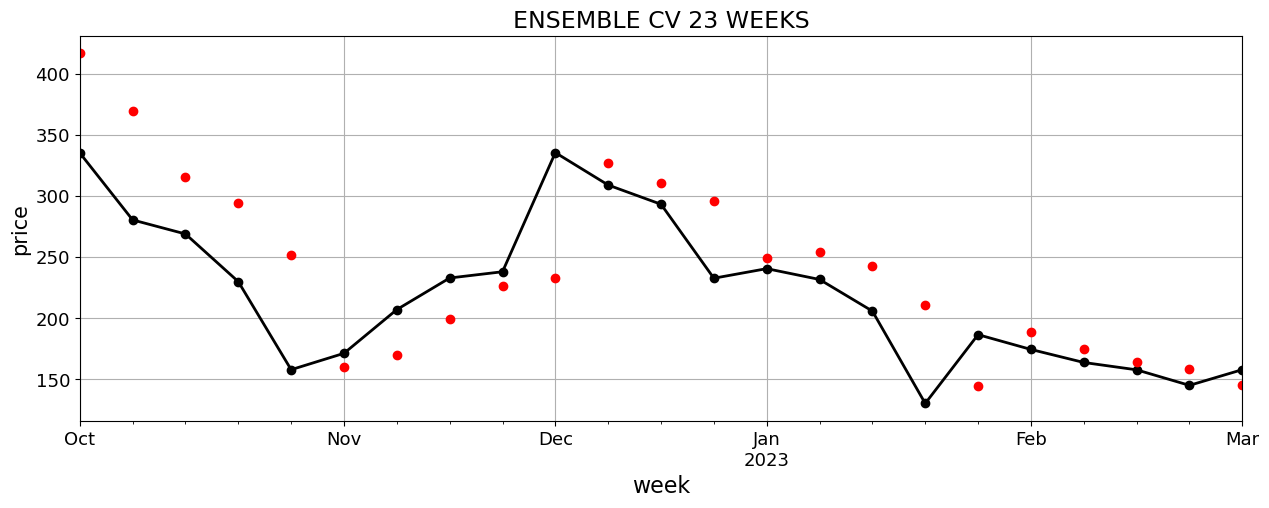

In [85]:
ax = data.iloc[-23:].plot(color='black',marker='o', figsize=(15,5), linewidth=2, fontsize = 13)
for i in range(len(cv_ensemble1)):
  cv_ensemble1['y_pred'].iloc[i].plot(ax=ax,color='red', marker = 'o')
ax.get_legend().remove()
plt.xlabel('week', fontsize = 16)
plt.ylabel('price', fontsize = 15)
plt.title('ENSEMBLE CV 23 WEEKS', fontsize = 17)
plt.grid()
plt.show()

## train metrics

In [53]:
enRMSEtrain = np.sqrt(np.square(enresid['price']).mean())
enMAPEtrain = np.absolute(enresid['price']).mean()
enMAEtrain = np.absolute(enresid['price']/train['price']).mean()

## test metrics

In [54]:
enRMSEtest = np.sqrt(cv_ensemble1["test_MeanSquaredError"]).mean()
enMAPEtest = cv_ensemble2["test_MeanAbsolutePercentageError"].mean()
enMAEtest = cv_ensemble3["test_MeanAbsoluteError"].mean()

## TOTAL METRICS

## train metrics

In [55]:
names = ('Weekly naive forecaster','Weekly ARIMA forecaster', 'Weekly AUTOARIMA forecaster','Weekly exponential smoothing forecaster', 'Weekly neutral network', 'Weekly ensemble') 
values = {'RMSE': [nRMSEtrain, aRMSEtrain, aaRMSEtrain, esRMSEtrain, nnRMSEtrain, enRMSEtrain], 'MAPE': [nMAPEtrain, aMAPEtrain, aaMAPEtrain, esMAPEtrain, nnMAPEtrain, enMAPEtrain], 'MAE': [nMAEtrain, aMAEtrain, aaMAEtrain, esMAEtrain, nnMAEtrain, enMAEtrain]}
metrics = pd.DataFrame(values, names)
metrics = metrics.sort_values(by=['RMSE'])
metrics.style.highlight_min()

## test metrics

In [56]:
names = ('Weekly naive forecaster','Weekly ARIMA forecaster', 'Weekly AUTOARIMA forecaster','Weekly exponential smoothing forecaster', 'Weekly neutral network', 'Weekly ensemble') 
values = {'RMSE': [nRMSEtest, aRMSEtest, aaRMSEtest, esRMSEtest, nnRMSEtest, enRMSEtest], 'MAPE': [nMAPEtest, aMAPEtest, aaMAPEtest, esMAPEtest, nnMAPEtest, enMAPEtest], 'MAE': [nMAEtest, aMAEtest, aaMAEtest, esMAEtest, nnMAEtest, enMAEtest]}
metrics = pd.DataFrame(values, names)
metrics = metrics.sort_values(by=['RMSE'])
metrics.style.highlight_min()